# Estimating Data Values from Plots in the Literature (Part 1)

::: {admonition} Learning Objectives  
After completing this lesson, you should be able to:  
1. open an image file into an interactive widget e.g. screen capture of a data plot from the literature,  
2. find the pixel coordinates of the data points in the plot,  
3. transform the pixel coordinates into plot coordinates correcting for any skew or rotation caused by copying the original paper on a copy machine, and  
4. replot the data and compare to original.  
:::

In the last lesson, [Selecting pixel coordinates from an image file](06_selecting_pixel_coordinates.ipynb), you saw how to make a matplotlib plot interactive which enabled you to select pixel coordinates from an object and perform calculations such as distance and area. This was done in a very simple manner.  Later in the course we will take a grain structure and calculate a grain size distribution in an automated method.  However, the last chapter does give us the basis for reproducing literature plots where we don't have access to the original data.   

:::{note}  
This lesson is particularly useful when you want to compare your data to similar data in the literature or when you want to reanalyze data in the literature to test a model.  ... think Senior Design Research.  
:::

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os

Let's open a screen capture that I saved of one of the figures from the journal article: Xiaojing Li, Zhaobin Qiu, *Crystallization kinetics, morphology, and mechanical properties of novel poly(ethylene succinate-co-octamethylene succinate)*, Polymer Testing, vol 48, pp. 125-132 (2015). 

## Read the image file with matplotlib
---

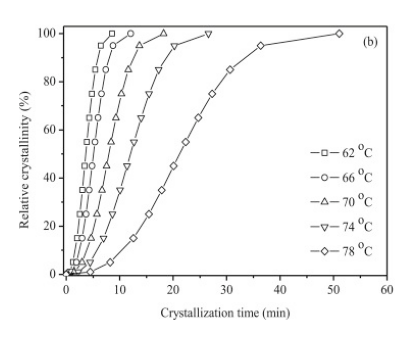

In [3]:
fig, ax = plt.subplots(figsize=[8,6])
ax.axis(False) #since this is an image, we don't need the x & y axis

# we use matplotlib.imread to read our image file and imshow to display it.
path=r'..\images' # ".." means go back one folder
filename ='crystallization kinetics poly testing 48 2015 p 125.png'
img = mpimg.imread(os.path.join(path, filename)) #matplotlib
ax=plt.imshow(img)

We want to determine if the data follows Avrami Kinetics: $1-X_t = \exp(-k t^n)$ where $X_t$ is the relative crystallinity fraction from 0 to 1.0.  If we take the Ln of both sides and then the log of both sides we get:  $log(-ln(1-xt)) = log(k) + n log(t)$.  To test, let's plot our data as $\log(-ln(1-X_t))$ versus $log(t)$ and see if it is linear according to the equation we just found.  

:::{admonition} Recall    
Recall we studied Avrami kinetics in MSE 2044 Introduction to Materials Engineering.  Specifically, we covered this material in Chapter 10 Phase Transformations in our textbook: William D. Callister Jr., David G. Rethwisch, Materials Science and Engineering: An Introduction, 10th Edition, 2018. ISBN: 978-1-119-40549-8  
:::

If we can get the pixel positions of known values on the image above (for example points along the x & y axes), then we can determine the transformation from pixel coordinates to plot coordinates for the image.  

## Developing code in small steps

[Step 1. Pixel position on an image](#first-write-code-to-get-the-pixel-position-of-a-mouse-click-on-an-image)   
[Step 2. Save pixel positions for multiple mouse clicks](#keep-track-of-mouse-clicks-and-shift-the-image-origin-to-bottom-left)   
[Step 3. Scatter plot of selected points in real time](#scatter-plot-of-selected-points-in-real-time)    
[Step 4. Determine the scaling for x and y axes](#determine-the-scaling-for-x-and-y-axes)   
[Step 5. Apply scaling and plot to confirm our code](#apply-scaling-and-plot-to-confirm-our-code)    

### First, write code to get the pixel position of a mouse click on an image  

To do this we will use **mpl_connect** which will look for "events" and report on them.  In our case the event we want is a "button press" (mouse click) event on an interactive matplotlib figure.  When the mouse is clicked, we call the function "onclick" which we define below to update the title on our plot.  The click event gives us access to the x & y coordinates of the click through the variables called event.xdata and event.ydata.  So here we go...

::: {note}  
Click on the image below to download.  
:::

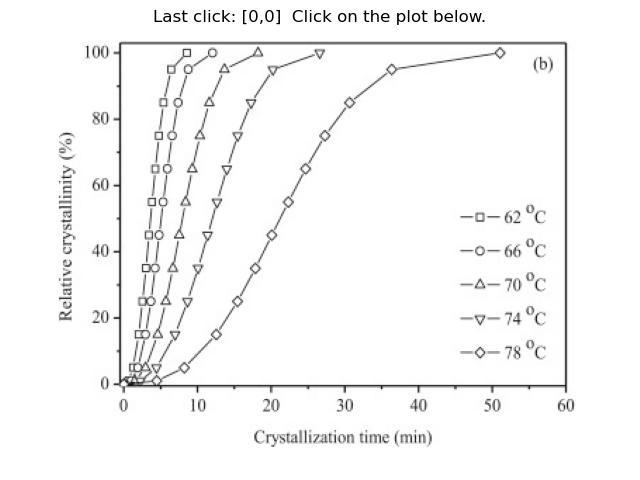

In [10]:
# produce matplotlib interactive output
%matplotlib widget 

fig, ax = plt.subplots()
ax.axis(False) #turning off display of x,y axes

# we use matplotlib.imread to read our image file and imshow to display it.
path=r'..\images'
filename ='crystallization kinetics poly testing 48 2015 p 125.png'
img = mpimg.imread(os.path.join(path, filename)) #matplotlib
ax=plt.imshow(img)
fig.tight_layout() #play with this line and see what it does
fig.suptitle(f'Last click: [0,0]  Click on the plot below.') #initializing the figure title (super title)

# here we define a function that we called "onclick" that changes the title when an "event" happens
def onclick(event):
    fig.suptitle(f'Last click: [{event.xdata:.1f}, {event.ydata:.1f}]') #button press event returns the xdata and ydata of the mouse position

# here we define the "event" as a button press and then call our function "onclick"
fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()


:::{image} ../images/07_step_1.png
:height: 400px
:name: navigator
:align: center
:::

In [13]:
from jupyterquiz import display_quiz

# tags:  remove-input
# menu: View/Cell toolbar/tags or in Jupyter lab use gear icon on top right
# this will remove the code below when building Jupyter-book 
# could also use remove-cell but this code has no output

example=[{
        "question": '''After running the code discussed above in your own notebook, click on a few points, what do you notice?''',
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "The y-coordinates don't seem correct.",
                "correct": True,
                "feedback": "Correct. "
                    "The origin is located in the upper left corner rather than the lower left "
                    "as in a data plot."
            },
            {
                "answer": "The y-coordinates look fine to me.",
                "correct": True,
                "feedback": "Yes, they certainly are correct but notice that the "
                    "origin is located in the upper left corner rather than the lower left "
                    "as in a data plot."
            },
            {
                "answer": "The x-coordinates don't look right.",
                "correct": False,
                "feedback": "Nothing wrong with the x-coordinates. Remember these are "
                    "pixel values and not plot values.  We will convert these below."
            }
        ]
    }]

In [14]:
print("The figure below is 'active.' Click on the answers for feedback.")
display_quiz(example);

The figure below is 'active.' Click on the answers for feedback.



### Keep track of mouse clicks and shift the image origin to bottom left


We can do this by initializing an empty list called "positions" and then appending the values of each click event.  We fix the y-axis by simply subtracting each y value by the total number of pixels of the image in the vertical direction, `img.shape[0]`.  Note: img.shape[1] would return the number of pixels in the horizontal direction.  The new lines of code are indicated below.  

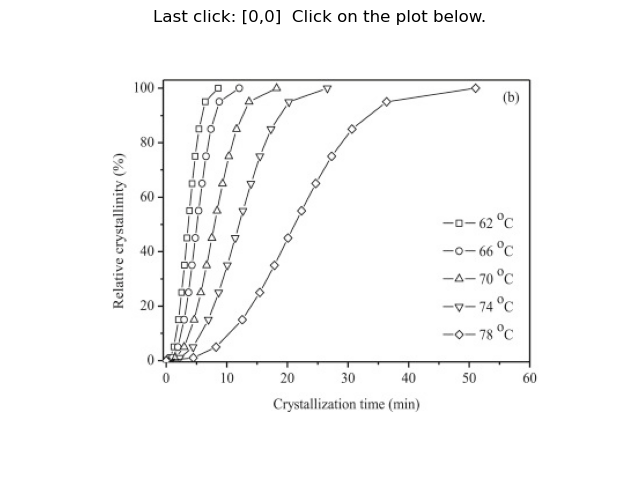

In [16]:
%matplotlib widget

fig, ax = plt.subplots()
ax.axis(False)

path=r'../images'
filename ='crystallization kinetics poly testing 48 2015 p 125.png'
img = mpimg.imread(os.path.join(path, filename)) 
ax=plt.imshow(img)

ydim=img.shape[0] # NEW LINE - get total number of pixels in the vertical direction

fig.suptitle(f'Last click: [0,0]  Click on the plot below.')

positions=[] #NEW LINE - initialize the list "positions"
def onclick(event):
    fig.suptitle(f'Last click: [{event.xdata:.1f}, {ydim-event.ydata:.1f}]') 
    positions.append([event.xdata,ydim-event.ydata]) # NEW LINE - append each click position to the list "positions"
    # notice that we corrected the yposition in line above:  "ydim-event.ydata"


fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

:::{image} ../images/07_step_2.png
:height: 400px
:name: navigator
:align: center
:::

In [17]:
# I clicked on each data point on the right most curve above
positions

[[322.77056277056283, 293.8333336636101],
 [246.5800865800866, 283.09740656072444],
 [218.8744588744589, 258.8549823183002],
 [198.961038961039, 234.61255807587594],
 [185.97402597402598, 211.23593469925254],
 [172.987012987013, 187.85931132262917],
 [162.5974025974026, 166.21428967760752],
 [151.34199134199136, 140.24026370358155],
 [138.35497835497836, 116.86364032695818],
 [122.77056277056278, 94.35281781613568],
 [100.25974025974028, 70.97619443951231],
 [79.48051948051949, 62.318185781503644],
 [56.96969696969697, 58.85498231830019]]

Let's plot the points from above. 

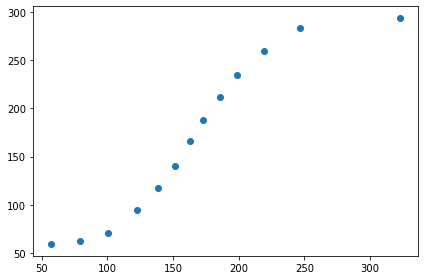

In [18]:
%matplotlib inline

xdata=np.array(positions)[:,0]
ydata=np.array(positions)[:,1]
fig, ax = plt.subplots()
ax.scatter(xdata, ydata)
fig.tight_layout()

In [26]:
example=[{
        "question": '''What are the units for the plot above?''',
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "x = pixel, y=pixel",
                "correct": True,
                "feedback": "Correct. "
                    "These are the x and y pixel positions for the data points in the image"
            },
            {
                "answer": "Both x and y axes are unitless",
                "correct": False,
                "feedback": "No, they have units. Try again."
            },
            {
                "answer": "x = minutes, y = %",
                "correct": False,
                "feedback": "(min,%) are the plot coordinates which we will get after we determine "
                    "the correct scaling to apply.  The points shown in the plot above are pixel values."
            }
        ]
    }]

In [27]:
print("The figure below is 'active.' Click on the answers for feedback.")
display_quiz(example);

The figure below is 'active.' Click on the answers for feedback.



### Scatter plot of selected points in real time

Changes in code below: 
1. Change subplots code to create 2 plots horizontally (1 row and 2 columns)
2. Set labels on the x and y axes
3. Add the scatter plot to our "onclick" function so the plot updates after each click

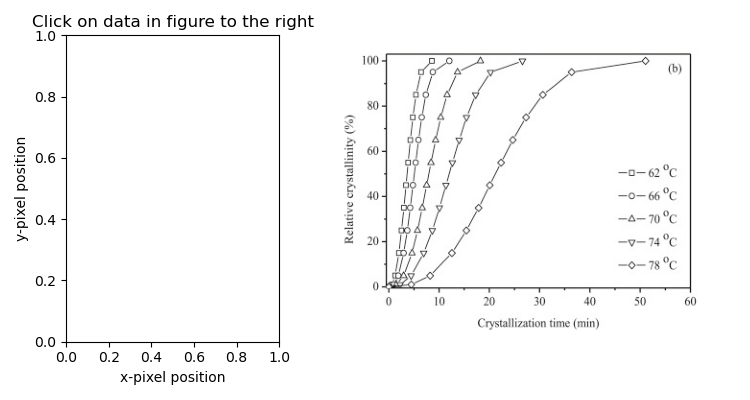

In [33]:
%matplotlib widget

#now we have 1 row and 2 columns i.e. 2 figures in a row
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(7.5, 4), gridspec_kw={'width_ratios': [1, 2]})
ax2.axis(False)

# we use matplotlib.imread to read our image file and imshow to display it.
path=r'..\images'
filename ='crystallization kinetics poly testing 48 2015 p 125.png'
img = mpimg.imread(os.path.join(path, filename)) 
ax2=plt.imshow(img)
#notice above we asigned the image to ax2 which is the image on the right

# recall from part 1 that image files have coord in left top corner so we need to correct by the y-dimension of the file
ydim=img.shape[0]

# setting title and labels for ax1 (figure on the left)
ax1.set_title('Click on data in figure to the right')
ax1.set_xlabel('x-pixel position')
ax1.set_ylabel('y-pixel position')

positions = []
def onclick(event):
    positions.append([event.xdata,ydim-event.ydata])
    ax1.set_title(f'Last click: [{event.xdata:.1f}, {ydim-event.ydata:.1f}]')
    ax1.scatter(event.xdata, ydim-event.ydata,marker='o', c='r', edgecolor='b') #adding scatter plot
    
fig.canvas.mpl_connect('button_press_event', onclick) 
fig.tight_layout()
plt.show()

:::{image} ../images/07_step_3.png
:height: 400px
:name: navigator
:align: center
:::

Here are the values for the points shown in the figure above.   

In [34]:
positions

[[324.2790873375642, 295.4033513004306],
 [248.03611362949528, 281.8258354346101],
 [218.79223330311277, 259.8929251898232],
 [199.99259595043816, 234.8267420529238],
 [187.4595043819885, 211.84940751076607],
 [173.881988516168, 189.9164972659791],
 [161.34889694771834, 165.89473842645057],
 [150.90465397401027, 141.872979586922],
 [136.28271381081902, 117.85122074739346],
 [122.70519794499853, 94.87388620523569],
 [99.7278634028408, 70.85212736570713],
 [80.92822605016624, 62.49673298674065],
 [56.906467210637686, 59.363460094628294]]

### Determine the scaling for x and y axes

The problem with the data above is that it is in units of "pixels" and not minutes and relative crystallinity so we need to transform this data into the units of our plot.  We could simply find a scale factor for the x and y axes separately and apply those to our pixel data.  However, if our image was obtained by scanning a hard copy of the original plot (or taking a photo of the plot with a phone) it will most likely contain rotation and skew for example, if your phone isn't perfectly level.  

We are going to use a more general method to calibrate the transformation from pixels to plot units.  This involves a transformation matrix, $m$, which you learned about or will learn in MSE 3134 Crystallography. We also include a translation correction (pixel offset).   

The general formula will be $m \cdot \ (pixel\ coord - \text{pixel offset}) = plot\ values$ where $m$ is the transformation matrix. In matrix notation, we have:  

$$\begin{bmatrix}m11 & m12 \\m21 & m22 \end{bmatrix}\cdot \left( \left[\begin{array}{c}pixX\\ pixY\end{array}\right] - \left[\begin{array}{c}Ox\\ Oy\end{array}\right]\right)=\left[\begin{array}{c}Xvalue\\ Yvalue\end{array}\right]$$

We have six unknowns, *m11, m12, m21, m22, Ox, Oy*, so we will need 6 total equations which we will get using just 3 points on our axes.  Each point gives us 2 equations; one for x and one for y. We need three known pixel coordinates, $(pixX1, pixY1)$,$(pixX2, pixY2)$,$(pixX3,pixY3)$ obtained by clicking on the axes and their corresponding plot coordinates, $(X1,Y1)$,$(X2,Y2)$,$(X3,Y3)$.

For our three calibration points, we will pick (1) a point along the x-axis (near the max value), (2) the plot origin (not necessarily (0,0) but it should be well defined), and (3) one point along the y-axis (near the max value). The plot below shows the three points chosen for this problem.  

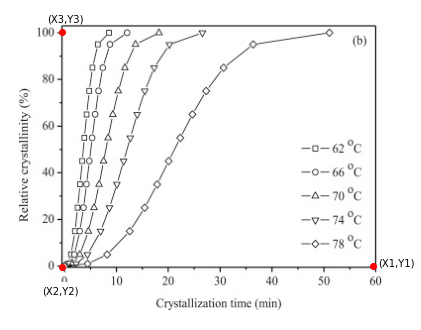

In [51]:
%matplotlib inline
path=r'..\images'
filename ='crystallization kinetics poly testing 48 2015 p 125.png'
img = mpimg.imread(os.path.join(path, filename)) 

fig, ax = plt.subplots(figsize=(6, 6))
ax=plt.imshow(img)
ydim=img.shape[0]

plt.plot([370,55,55], np.array([262,25.3,263]),'ro')
plt.text(375,262, "(X1,Y1)")
plt.text(40,15, "(X3,Y3)")
plt.text(35,290, "(X2,Y2)", backgroundcolor='white')
plt.axis(False)
plt.tight_layout()
plt.show()

#### from the plot above the three points I chose are:  
1. (60 min, 0 %)
2. (0 min, 0 %)
3. (0 min, 100 %)

#### and the corresponding pixel coordinates for these are:  
1. (371.6, 59.1)
2. (56.1, 60.2)
3. (55.1, 296.2)

Using these three points, we get 3 sets of two equations (one for x and one for y) for a total of 6 equations.  

In [153]:
from sympy import solve, Eq, symbols, Matrix

(m11, m12, m21, m22, Ox, Oy) = symbols('m11, m12, m21, m22, Ox, Oy')
(pix_X1,pix_Y1,pix_X2,pix_Y2,pix_X3,pix_Y3) = symbols('pix_X1,pix_Y1,pix_X2,pix_Y2,pix_X3,pix_Y3')
(X1,Y1,X2,Y2,X3,Y3) = symbols('X1,Y1,X2,Y2,X3,Y3')

In [171]:
display(Eq(m*(Matrix([pix_X1,pix_Y1])-offset),Matrix([X1, Y1])).subs([(pix_X1,371.6),(pix_Y1,59.1),(X1,60),(Y1,0)]))
display(Eq(m*(Matrix([pix_X2, pix_Y2])-offset),Matrix([X2, Y2])).subs([(pix_X2,56.1),(pix_Y2,60.2),(X2,0),(Y2,0)]))
display(Eq(m*(Matrix([pix_X3, pix_Y3])-offset),Matrix([X3, Y3])).subs([(pix_X3,55.1),(pix_Y3,296.2),(X3,0),(Y3,100)]))

Eq(Matrix([
[m11*(371.6 - Ox) + m12*(59.1 - Oy)],
[m21*(371.6 - Ox) + m22*(59.1 - Oy)]]), Matrix([
[60],
[ 0]]))

Eq(Matrix([
[m11*(56.1 - Ox) + m12*(60.2 - Oy)],
[m21*(56.1 - Ox) + m22*(60.2 - Oy)]]), Matrix([
[0],
[0]]))

Eq(Matrix([
[m11*(55.1 - Ox) + m12*(296.2 - Oy)],
[m21*(55.1 - Ox) + m22*(296.2 - Oy)]]), Matrix([
[  0],
[100]]))

To solve equations that contain variables (symbols), we need to import sympy (symbolic python)

In [36]:
from sympy import solve, Eq, symbols, Matrix

Any variable in our equations that has not been assigned a numeric value, must be declared as a symbol using `symbols()` from sympy.  

:::{important}  
Note the syntax for defining symbols shown below.  The left side does not contain brackets.  This is the normal way of assigning multiple variables to multiple values at one time.  The right side also does not have brackets inside the function `symbols()` but does enclose the same variable list in the same order within quotes, ' '.  
:::

In [37]:
# define the symbols in our equations
m11, m12, m21, m22, Ox, Oy = symbols('m11, m12, m21, m22, Ox, Oy')
# define transformation matrix and offset matrix
m = Matrix([[m11, m12],[m21, m22]])
offset=Matrix([Ox,Oy])

We define our equations below using Eq("left side", "right side").  We need this because in python "=" is for assigning values to variables and "==" is a test that returns True or False.  

In [39]:
# define our 3 sets of equations in matrix form

eq1=Eq(m*(Matrix([371.6, 59.1])-offset), Matrix([60, 0]))

eq2=Eq(m*(Matrix([56.1, 60.2])-offset), Matrix([0, 0]))

eq3=Eq(m*(Matrix([55.1, 296.2])-offset), Matrix([0,100]))

Now we can solve for our symbols using `solve()` which is also part of sympy. 

In [40]:
# solve for matrix, m, and vector, O
print('\n Our solution: ')
sol=solve([eq1,eq2,eq3])
sol


 Our solution: 


[{Ox: 56.1000000000000,
  Oy: 60.2000000000000,
  m11: 0.190177136034404,
  m12: 0.000805835322179677,
  m21: 0.00147736475732941,
  m22: 0.423735073579480}]

Our solution printed above is called a dictionary (actually `sol[0]` is the dictionary). The form above has an extra set of brackets, [ ]). `sol[0]` has the form {key1: value1, key2:value2, etc}. To use this solution, we use sympy to substitute, `.subs()`, these values directly in for our matrix and offset.    

In [41]:
print('The matrix, m, is:')
display(m.subs(sol[0]))
print('The offset vector is:')
display(offset.subs(sol[0]))

The matrix, m, is:


Matrix([
[  0.190177136034404, 0.000805835322179677],
[0.00147736475732941,     0.42373507357948]])

The offset vector is:


Matrix([
[56.1],
[60.2]])

Save our calibrated matrix, m, and the offset.  

In [42]:
# define variables m_cal and offset_cal
m_cal = m.subs(sol[0]) # get the calibrated transformation matrix, m_cal
offset_cal = offset.subs(sol[0]) # get the calibrated offset, offset_cal

Now that we know, m_cal and offset_cal, we can take any pixel coordinate, $(pixX, pixY)$, from the plot and convert it directly to plot coordinates, $(Xvalue, Yvalue)$ by substitution into:   

$$\left[\begin{array}{c}Xplot\\ Yplot\end{array}\right]=\begin{bmatrix}0.1902 & 0.0008058 \\0.0014774 & 0.42374 \end{bmatrix}\cdot \left( \left[\begin{array}{c}pixX\\ pixY\end{array}\right] - \left[\begin{array}{c}56.1\\ 60.2\end{array}\right]\right)$$



### Apply scaling and plot to confirm our code

Let's write a function to perform this conversion. 

In [43]:
# converts pixels position to plot coordinates using the calibration above
def conv(pix_coords, m_cal, offset_cal):
    return(list(m_cal*(Matrix(pix_coords)-offset_cal)))

# test it: recall that plot point (60,0) had pix coord of (371.6,59.1)
# so placing (371.6,59.1) into our function conv() should give us (60,0)
conv([371.6, 59.1], m_cal, offset_cal)

[60.0000000000000, -6.10622663543836e-16]

The output above looks good! 6.1e-16 is close enough to call zero. 

Let's apply `conv()` to each point in the list 'positions' to get the corresponding plot values in units of (minutes, %). 

:::{note}  
Notice that we avoided writing a for loop below by using the python *comprehension* format. 
```python
[calculation_with_output for variable in list]
```
:::

In [45]:
plot_data=[conv(pixel_point, m_cal, offset_cal) for pixel_point in positions]
plot_data

[[51.1910659425511, 100.060107701714],
 [36.6804543181321, 94.1941993349333],
 [31.1012625973344, 84.8572521203846],
 [27.5058021913534, 74.2080572428384],
 [25.1037787834251, 64.4532387521732],
 [22.5039713878082, 55.1394364723541],
 [20.1011063458898, 44.9420587751943],
 [18.0954925473287, 34.7477670693318],
 [15.2953762620528, 24.5473033808748],
 [12.6947272324458, 14.7909418945610],
 [8.30560597374009, 4.57813424091484],
 [4.72361171160173, 1.00988666728249],
 [0.152697511020568, -0.353279852119914]]

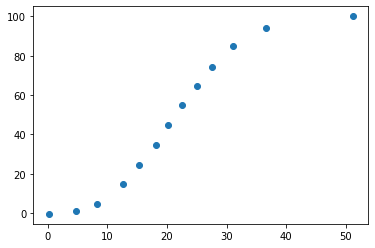

In [46]:
# plot our converted data
xdata=np.array(plot_data)[:,0]
ydata=np.array(plot_data)[:,1]
fig, ax = plt.subplots()
ax.scatter(xdata, ydata)
plt.show()

#### Let's compare to the original image

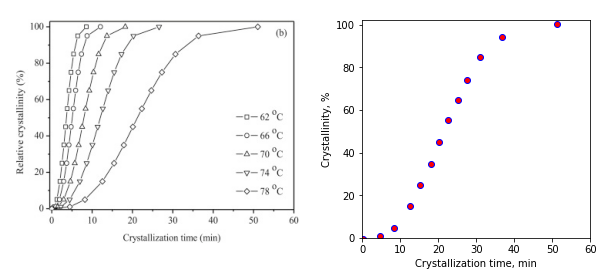

In [47]:
%matplotlib inline

#now we have 1 row and 2 columns i.e. 2 figures in a row
fig3_1, (ax3_1, ax3_2) = plt.subplots(nrows=1, ncols=2,figsize=(9, 4))

ax3_1.clear()
ax3_2.clear()

#set the scatter plot for axes 3_2 i.e. the right plot
ax3_2.scatter(np.array(plot_data)[:,0],np.array(plot_data)[:,1],marker='o', c='r', edgecolor='b');
ax3_2.set_xlabel('Crystallization time, min')
ax3_2.set_ylabel('Crystallinity, %');
ax3_2.set_xlim(0,60)
ax3_2.set_ylim(0,102)

# turn off the x, y axis on the image - the axis doesn't make sense for an image
ax3_1.axis(False)

# we use matplotlib.imread to read our image file and imshow to display it.
path=r'..\images'
filename ='crystallization kinetics poly testing 48 2015 p 125.png'
img2 = mpimg.imread(os.path.join(path, filename)) 

# This is the better way to display images along with normal plots
# You have to use the .add_axes function to place the image in your figure
# The image could even overlap another plot if you want. Play with the numbers to see what happens
# .add_axes([left, bottom, width, height]) all values are fractions of the overall figure size
# zorder allows you to place images in front of other images or plots.  0 = place behind, 10 = in front
image_axis = fig3_1.add_axes([0, 0, 0.47, 1], zorder=10, anchor=(0.5,0.5)) #zorder places figure on top of anything else in axes
image_axis.imshow(img2)
image_axis.axis('off')
 
plt.show()

This looks pretty nice!

:::{admonition} Think about it...
Take a look at the last point in `plot_data`, $[0.15270, -0.3538]$. Why did we get a negative value for the relative crystallinity? There is always some error in our picking points off of the image. Based on that, could -0.3538 just as likely be +0.3538? Try clicking on the first point near (0,0) multiple times and see what kind of error you get.  We will have to deal with this negative value if we wish to plot our data on a log scale i.e., we can't take the log of a negative number.  
:::

**Next time we will perform an avrami analysis on the data obtained in this lesson.**

## Exercises

### Problem 1

Reproduce the $74 ^{\circ}C$ data in the plot below. Make sure you label your axes and plot your points as down triangles as shown in the figure. Your plot should be in units of minutes (x-axis) and % (y-axis). Connect your points with a dotted line (not dashed line).   

:::{image} ../images/crystallization\ kinetics\ poly\ testing\ 48\ 2015\ p\ 125.png
:height: 600px
:name: navigator
:align: center
:::

<img alt="" src="../images/crystallization kinetics poly testing 48 2015 p 125.png" width=500px>

### Problem 2

Reproduce the overall curve below. Treat all the data points as one set i.e., you don't need to separate out the various symbols.  You should select at least 20 points along the curve.  Make sure you label your axes including the superscripts and subscripts on the y-axis. The y-axis label can be rotated and written as one line vertically (the default mode for matplotlib). Also add a title to your plot. Your final plot should no longer have any of the skew or rotation from the original plot. Pretty nice!

:::{image} ../images/07_hw_skew.png
:height: 500px
:name: navigator
:align: center
:::

<img alt="" src="../images/07_hw_skew.png" width=500px>

### Problem 3

Reproduce the $2\theta$ peak positions in the plot below using our calibration routine in this lesson. The Intensity is arbitrary so just assign the max value on the y-axis = 1. Use these values to answer the following:  

The x-ray pattern below is for BCC Tungsten.  The indices of the peaks (from left to right) are (110), (200), (211), (220), and (310).  (1) Calculate the interplanar spacing (d-spacing) for each peak.  (2) From each of the d-spacings, calculate the radius of tungsten.  (3) Find the mean and standard deviation of the radii. This is easily done if you store your radii in a numpy array.  You can use for example: `np.std()` and `np.mean()`.  These are 1st order reflections so n = 1. Some useful equations: 

\begin{eqnarray}
2\ d_{hkl}\ \sin(\theta)=n\ \lambda \\
a=d_{hkl}\ \sqrt{h^2+k^2+l^2}
\end{eqnarray}

The x-ray source was $Cu\ K_{\alpha}$ with a $\lambda\ =\ 0.1542\ nm$.  The relationship between lattice parameter, $a$, and radius, $R$, for a BCC material you should know from MSE 2044.  

<img alt="" src="../images/diffraction.png" width=500px>

:::{image} ../images/diffraction.png
:height: 600px
:name: navigator
:align: center
:::